In [171]:
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [172]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import ADASYN, SMOTE
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from xgboost import XGBClassifier

Model is trained and tested on the fourth_batch with train test split.

In [173]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [174]:
def engineer_features(df_X, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        count_dislike=("rating", lambda x: (x == -10).sum()),
        count_neutral=("rating", lambda x: (x == 0).sum()),
        count_like=("rating", lambda x: (x == 10).sum()),
        count_watched=("rating", lambda x: (x == 1).sum()),
        total_interactions=("rating", "count"),
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )
    df_user_features["watched_ratio"] = (
        df_user_features["count_watched"] / df_user_features["total_interactions"]
    )

    # Weighted scores
    df_user_features["weighted_score"] = (
        df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
    )

    # Item popularity metrics
    item_popularity = df_X.groupby("item")["rating"].agg(["mean", "count"])
    item_popularity["popularity_score"] = item_popularity["mean"] * np.log1p(
        item_popularity["count"]
    )

    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(
        df_X, item_popularity["popularity_score"], left_on="item", right_index=True
    )

    # New features
    df_user_features["avg_deviation_from_popularity"] = df_X_with_popularity.groupby(
        "user"
    ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())

    # Drop columns with high correlation
    # Count watch has high correlation with total interactions
    df_user_features.drop(columns=["total_interactions"], inplace=True)

    # Drop columns with low mutual information
    df_user_features.drop(columns=["median_rating"], inplace=True)
    df_user_features.drop(columns=["mean_rating"], inplace=True)

    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on="user")
        # Return the merged dataframe with selected features, label, and top features
        return df_merged
    else:
        return df_user_features

In [175]:
# Load fourth batch data
fourth_data = np.load("../data/first_to_fourth.npz")
fourth_interaction_data = pd.DataFrame(
    fourth_data["X"], columns=["user", "item", "rating"]
)
fourth_user_labels = pd.DataFrame(fourth_data["yy"], columns=["user", "label"])
fourth_users = fourth_user_labels["user"].unique()

# Load fifth batch data
fifth_data = np.load("../data/fifth_batch_multi.npz")
fifth_interaction_data = pd.DataFrame(
    fifth_data["X"], columns=["user", "item", "rating"]
)
fifth_users = np.unique(fifth_interaction_data["user"])


fourth_users

array([   0,    1,    2, ..., 3787, 3788, 3789])

In [176]:
fifth_users

array([3790, 3791, 3792, ..., 5437, 5438, 5439])

In [177]:
fourth_fifth_interaction_data = pd.concat(
    [fourth_interaction_data, fifth_interaction_data]
)

fourth_fifth_features = engineer_features(fourth_fifth_interaction_data)

fourth_fifth_features

/var/folders/p2/sdxgwhg55dzc67hr8x63hdv80000gn/T/ipykernel_84640/4103061591.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
0,6.167758,20,24,32,57,0.240602,0.150376,0.180451,0.428571,18.0,-0.307358,19.668080
1,5.238997,8,26,19,39,0.206522,0.086957,0.282609,0.423913,16.5,0.535412,15.304350
2,7.380911,32,6,52,58,0.351351,0.216216,0.040541,0.391892,30.0,-1.037700,13.529248
3,6.107906,36,48,43,85,0.202830,0.169811,0.226415,0.400943,10.5,-0.280708,18.833229
4,4.686725,11,54,42,103,0.200000,0.052381,0.257143,0.490476,46.5,0.999560,18.165345
...,...,...,...,...,...,...,...,...,...,...,...,...
5435,6.040867,4,12,15,13,0.340909,0.090909,0.272727,0.295455,16.5,-0.346299,19.606595
5436,5.705941,5,17,42,30,0.446809,0.053191,0.180851,0.319149,55.5,-0.322267,17.094011
5437,5.259704,8,39,123,98,0.458955,0.029851,0.145522,0.365672,172.5,-0.517903,14.712684


In [178]:
# Remove fifth batch users from the fourth fifth features by row index
fourth_features = fourth_fifth_features.drop(
    fourth_fifth_features.index[fourth_fifth_features.index.isin(fifth_users)]
)

fourth_features

,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
0,6.167758,20,24,32,57,0.240602,0.150376,0.180451,0.428571,18.0,-0.307358,19.668080
1,5.238997,8,26,19,39,0.206522,0.086957,0.282609,0.423913,16.5,0.535412,15.304350
2,7.380911,32,6,52,58,0.351351,0.216216,0.040541,0.391892,30.0,-1.037700,13.529248
3,6.107906,36,48,43,85,0.202830,0.169811,0.226415,0.400943,10.5,-0.280708,18.833229
4,4.686725,11,54,42,103,0.200000,0.052381,0.257143,0.490476,46.5,0.999560,18.165345
...,...,...,...,...,...,...,...,...,...,...,...,...
3785,4.502136,0,3,4,6,0.307692,0.000000,0.230769,0.461538,6.0,-1.309731,9.049169
3786,6.429423,138,102,54,149,0.121896,0.311512,0.230248,0.336343,-126.0,-0.781821,15.076317
3787,4.962127,3,33,124,72,0.534483,0.012931,0.142241,0.310345,181.5,-0.956307,13.475176


In [179]:
fourth_X = fourth_features
fourth_y = fourth_user_labels["label"]

# Step 1: Split data into 80% for nested cross-validation and 20% for final evaluation
X_train, X_holdout, y_train, y_holdout = train_test_split(
    fourth_X, fourth_y, test_size=0.2, random_state=RANDOM_SEED, stratify=fourth_y
)

print(X_train.shape, X_holdout.shape)

(3032, 12) (758, 12)


In [180]:
print(y_holdout.value_counts())

label
0    700
1     29
2     29
Name: count, dtype: int64


In [181]:
# Upsample the minority class using SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train = X_train_resampled
y_train = y_train_resampled

In [182]:
# Scale fourth_fifth_features using StandardScaler and replace the original features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

X_train_scaled = pd.DataFrame(
    X_train_scaled, index=X_train.index, columns=X_train.columns
)
X_holdout_scaled = pd.DataFrame(
    X_holdout_scaled, index=X_holdout.index, columns=X_holdout.columns
)

In [183]:
# Step 2: Define the inner and outer cross-validation strategy
outer_cv = KFold(
    n_splits=5, shuffle=True, random_state=42
)  # Outer loop for model evaluation
inner_cv = KFold(
    n_splits=3, shuffle=True, random_state=42
)  # Inner loop for hyperparameter tuning

In [184]:
def plot_multiclass_roc_curve(y_true, y_pred_probabilities, class_labels=[0, 1, 2]):
    # Convert labels to binary format
    binarized_labels = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = binarized_labels.shape[1]

    # Initialize dictionaries to store metrics
    false_positive_rates = {}
    true_positive_rates = {}
    auc_scores = {}

    # Create color map for plotting
    colors = ["blue", "green", "red"]

    # Create plot
    plt.figure()

    # Calculate ROC curve and AUC for each class
    for class_idx in range(n_classes):
        # Calculate ROC curve metrics
        false_positive_rates[class_idx], true_positive_rates[class_idx], _ = roc_curve(
            binarized_labels[:, class_idx], y_pred_probabilities[:, class_idx]
        )
        # Calculate AUC score
        auc_scores[class_idx] = auc(
            false_positive_rates[class_idx], true_positive_rates[class_idx]
        )

        # Plot ROC curve for current class
        class_label = (
            f"{class_labels[class_idx]}" if class_labels else f"Class {class_idx}"
        )
        plt.plot(
            false_positive_rates[class_idx],
            true_positive_rates[class_idx],
            color=colors[class_idx],
            lw=2,
            label=f"{class_label} (AUC = {auc_scores[class_idx]:.3f})",
        )

    # Calculate and plot average AUC
    average_auc = sum(auc_scores.values()) / n_classes

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.text(0.6, 0.3, f"Average AUC Score: {average_auc:.4f}")
    plt.legend(loc="lower right")

    # Show plot
    plt.grid(True, alpha=0.3)
    plt.show()

In [185]:
def calculate_multiclass_roc_auc(y_true, y_pred_proba):
    n_classes = y_pred_proba.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

    # Calculate AUC for each class
    auc_scores = {}
    for i in range(n_classes):
        if (
            len(np.unique(y_true_bin[:, i])) > 1
        ):  # Check if the class exists in this fold
            auc_scores[f"class_{i}"] = roc_auc_score(
                y_true_bin[:, i], y_pred_proba[:, i]
            )

    # Calculate macro average
    macro_auc = np.mean(list(auc_scores.values()))

    return macro_auc, auc_scores


Fold Results:
Macro Average AUC: 0.977
Class-specific AUC scores:
class_0: 0.970
class_1: 0.966
class_2: 0.994


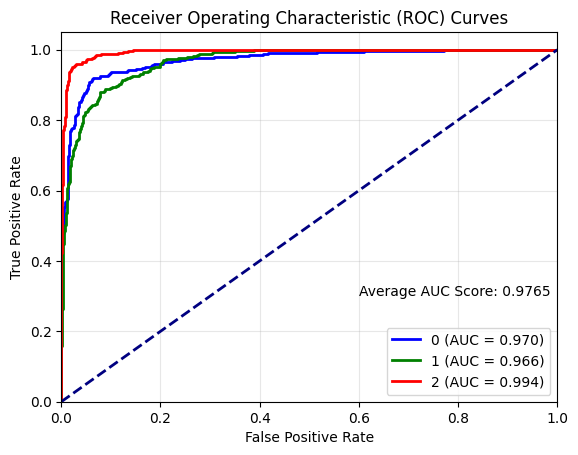


Fold Results:
Macro Average AUC: 0.978
Class-specific AUC scores:
class_0: 0.970
class_1: 0.971
class_2: 0.993


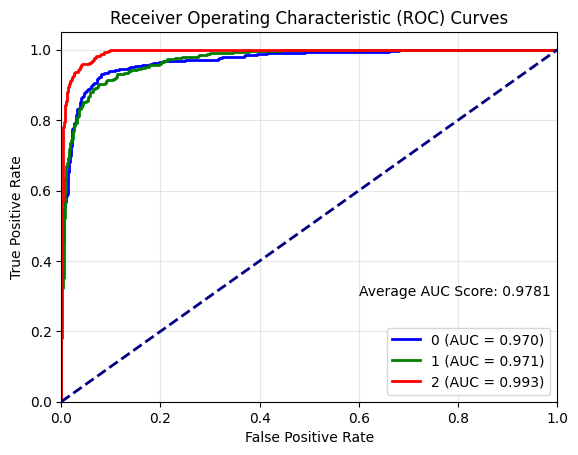


Fold Results:
Macro Average AUC: 0.974
Class-specific AUC scores:
class_0: 0.961
class_1: 0.969
class_2: 0.993


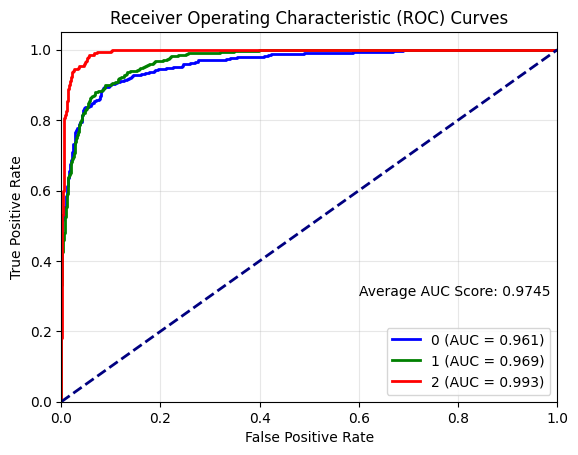


Fold Results:
Macro Average AUC: 0.977
Class-specific AUC scores:
class_0: 0.967
class_1: 0.970
class_2: 0.995


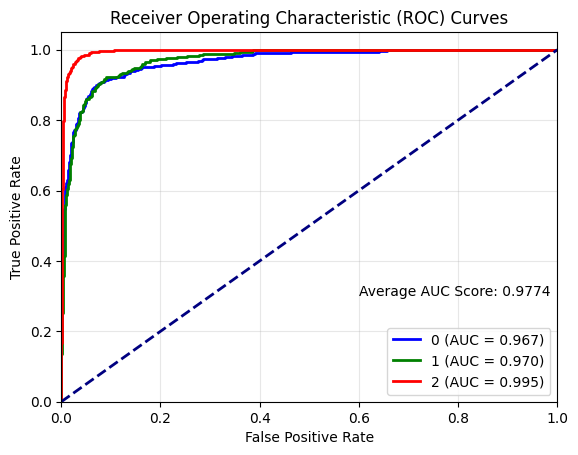

/Users/milton/Documents/GitHub/cs421-milton-project/venv-3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Fold Results:
Macro Average AUC: 0.976
Class-specific AUC scores:
class_0: 0.967
class_1: 0.967
class_2: 0.993


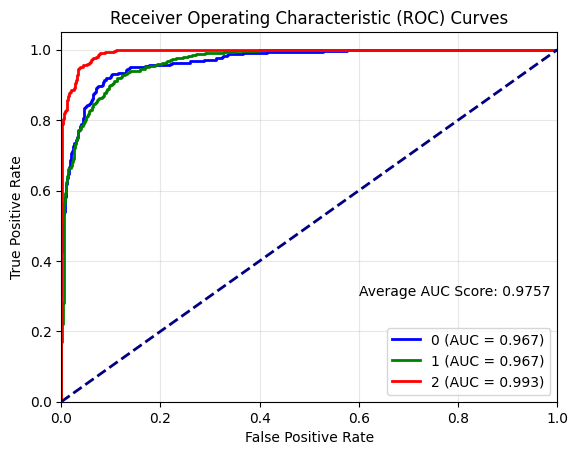


Final Nested CV Results:
Average Macro AUC: 0.976 ± 0.001


In [186]:
# Step 3: Define the model and hyperparameter grid
# Define Logistic Regression model
logreg_model = LogisticRegression(random_state=RANDOM_SEED)

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)

param_grid_voting = {
    # Logistic Regression parameters
    "voting__logreg__C": [10.0],  # Best value
    "voting__logreg__class_weight": [{0: 1, 1: 1.5, 2: 1}],  # Best value
    "voting__logreg__penalty": ["l2"],  # Best value
    "voting__logreg__solver": ["lbfgs"],  # Best value
    
    # Random Forest parameters
    "voting__rf__max_depth": [None],  # Best value
    "voting__rf__max_features": [0.7],  # Best value
    "voting__rf__min_samples_leaf": [2],  # Best value
    "voting__rf__min_samples_split": [2],  # Best value
    "voting__rf__n_estimators": [200],  # Best value
    
    # Add voting weights
    "voting__weights": [[1.5, 1]]  # Best value
}

# Define the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ("logreg", logreg_model),
        ("rf", rf_model),
    ],
    voting="soft",  # Use 'soft' voting to combine predicted probabilities
)

# Create a pipeline with a Voting Classifier
pipeline = Pipeline([("voting", voting_clf)])

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_voting,
    scoring="roc_auc_ovr",
    cv=inner_cv,
    n_jobs=-1,
)

# Perform nested cross-validation
outer_scores = []
class_specific_scores = []

for train_index, test_index in outer_cv.split(X_train_scaled):
    # Split data for current fold
    X_train_fold, X_test_fold = (
        X_train_scaled.iloc[train_index],
        X_train_scaled.iloc[test_index],
    )
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit GridSearchCV
    grid_search.fit(X_train_fold, y_train_fold)

    # Get predictions
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_fold)

    # Calculate AUC scores
    macro_auc, class_aucs = calculate_multiclass_roc_auc(y_test_fold, y_pred_proba)
    outer_scores.append(macro_auc)
    class_specific_scores.append(class_aucs)

    # Display results for current fold
    print(f"\nFold Results:")
    print(f"Macro Average AUC: {macro_auc:.3f}")
    print("Class-specific AUC scores:")
    for class_name, auc_score in class_aucs.items():
        print(f"{class_name}: {auc_score:.3f}")

    # Plot ROC curve for current fold
    plot_multiclass_roc_curve(
        y_test_fold,
        y_pred_proba,
    )

# Display final nested CV results
print("\nFinal Nested CV Results:")
print("Average Macro AUC: %.3f ± %.3f" % (np.mean(outer_scores), np.std(outer_scores)))

Best Hyperparameters: {'voting__logreg__C': 10.0, 'voting__logreg__class_weight': {0: 1, 1: 1.5, 2: 1}, 'voting__logreg__penalty': 'l2', 'voting__logreg__solver': 'lbfgs', 'voting__rf__max_depth': None, 'voting__rf__max_features': 0.7, 'voting__rf__min_samples_leaf': 2, 'voting__rf__min_samples_split': 2, 'voting__rf__n_estimators': 200, 'voting__weights': [1.5, 1]}


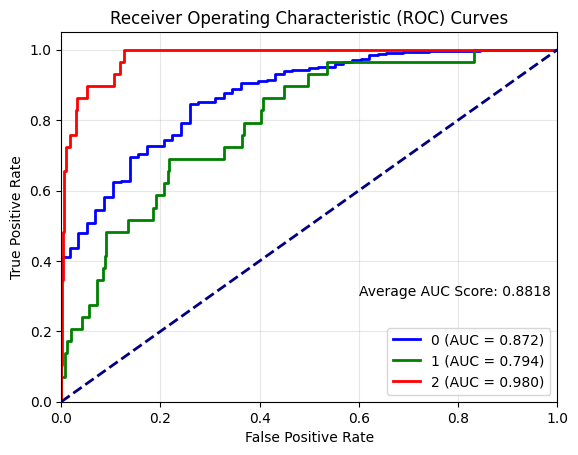

In [187]:
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Step 7: Evaluate the final model on the holdout set
# Refit the model with best parameters from the whole training data
best_model_final = grid_search.best_estimator_
best_model_final.fit(X_train_scaled, y_train)

# Test on holdout set and display ROC curve
y_holdout_pred_probabilities = best_model_final.predict_proba(X_holdout_scaled)
plot_multiclass_roc_curve(y_holdout, y_holdout_pred_probabilities)

In [188]:
fifth_data_with_labels = np.load("../data/fifth_batch_multi_labels.npz")
fifth_user_labels = pd.DataFrame(
    fifth_data_with_labels["yy"], columns=["user", "label"]
)

# Remove fourth batch users from the fifth features by row index
fifth_features = fourth_fifth_features.drop(
    fourth_fifth_features.index[fourth_fifth_features.index.isin(fourth_users)]
)

fifth_features

,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
3790,5.480485,1,3,17,7,0.607143,0.035714,0.107143,0.250000,24.0,0.299984,12.171846
3791,8.989782,6,1,7,3,0.411765,0.352941,0.058824,0.176471,1.5,-1.663088,24.753617
3792,7.011842,19,21,45,32,0.384615,0.162393,0.179487,0.273504,39.0,-0.816920,13.923927
3793,4.976308,0,3,5,3,0.454545,0.000000,0.272727,0.272727,7.5,-1.948977,18.459541
3794,4.826087,12,91,47,73,0.210762,0.053812,0.408072,0.327354,52.5,0.705454,17.306588
...,...,...,...,...,...,...,...,...,...,...,...,...
5435,6.040867,4,12,15,13,0.340909,0.090909,0.272727,0.295455,16.5,-0.346299,19.606595
5436,5.705941,5,17,42,30,0.446809,0.053191,0.180851,0.319149,55.5,-0.322267,17.094011
5437,5.259704,8,39,123,98,0.458955,0.029851,0.145522,0.365672,172.5,-0.517903,14.712684


In [189]:
fifth_features_scaled = scaler.transform(fifth_features)

fifth_features_scaled = pd.DataFrame(
    fifth_features_scaled, index=fifth_features.index, columns=fifth_features.columns
)

fifth_features_scaled

,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
3790,0.002496,-0.752307,-0.756058,-0.537859,-1.047646,3.555934,-0.975750,-0.314928,-2.665102,0.100401,0.377593,-1.852653
3791,4.205776,-0.547103,-0.846652,-0.881753,-1.107719,1.676057,2.835457,-1.043945,-3.397723,-0.459634,-1.919180,2.330394
3792,1.836688,-0.013573,0.059285,0.425045,-0.672189,1.414833,0.546187,0.776565,-2.430914,0.473757,-0.929173,-1.270140
3793,-0.601385,-0.793347,-0.756058,-0.950531,-1.107719,2.087682,-1.404826,2.183322,-2.438656,-0.310291,-2.253668,0.237810
3794,-0.781312,-0.300858,3.230063,0.493824,-0.056438,-0.257936,-0.758326,4.225328,-1.894372,0.809777,0.851989,-0.145511
...,...,...,...,...,...,...,...,...,...,...,...,...
5435,0.673697,-0.629184,-0.348387,-0.606637,-0.957536,0.994302,-0.312632,2.183322,-2.212209,-0.086278,-0.378552,0.619169
5436,0.272538,-0.588144,-0.121902,0.321877,-0.702225,2.013239,-0.765776,0.797142,-1.976127,0.884449,-0.350434,-0.216186
5437,-0.261945,-0.465021,0.874628,3.107419,0.319019,2.130111,-1.046195,0.264122,-1.512591,3.796627,-0.579326,-1.007903


In [190]:
y_pred_proba_fifth = best_model_final.predict_proba(fifth_features_scaled)

df_predictions_fifth = pd.DataFrame(
    {
        "user": fifth_user_labels.index,
        "z0": y_pred_proba_fifth[:, 0],
        "z1": y_pred_proba_fifth[:, 1],
        "z2": y_pred_proba_fifth[:, 2],
        "predicted_class": np.argmax(y_pred_proba_fifth, axis=1),
    }
).set_index("user")

df_predictions_fifth = df_predictions_fifth.join(fifth_user_labels)

df_predictions_fifth

,z0,z1,z2,predicted_class,user,label
user,,,,,,
0,0.849007,0.150993,1.374148e-13,0,3790,0
1,0.709745,0.267725,2.253005e-02,0,3791,0
2,0.742136,0.237565,2.029919e-02,0,3792,0
3,0.761626,0.237024,1.350697e-03,0,3793,0
4,0.943677,0.056323,2.172411e-10,0,3794,0
...,...,...,...,...,...,...
1645,0.676154,0.319548,4.297983e-03,0,5435,0
1646,0.883564,0.116435,1.072454e-06,0,5436,0
1647,0.995865,0.004135,1.111638e-07,0,5437,0


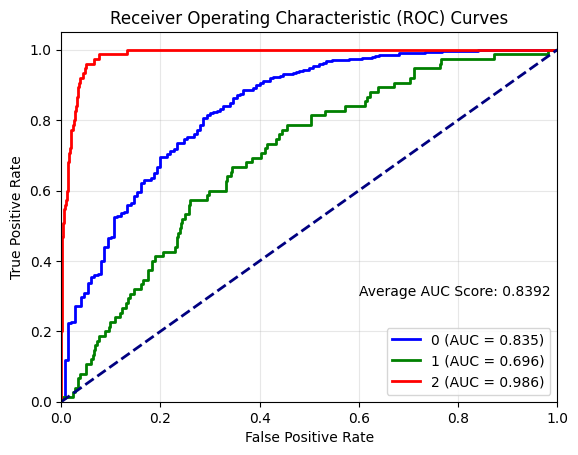

In [191]:
plot_multiclass_roc_curve(df_predictions_fifth["label"], y_pred_proba_fifth)